# DataPreprocessing

1. Initializing spark session

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Pyspark Data Preprocessing") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

2. Loading data

In [2]:
df = spark.read.csv('Data/AB_US_2020.csv', header= True, inferSchema= True, multiLine=True, quote='"', escape='"')
df.show(3)
df.printSchema()

+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------+
|    id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|     city|
+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------+
| 38585|Charming Victoria...| 165529|  Evelyne|               null|        28804|35.65146|-82.62792|   Private room|   60|             1|              138|   16/02/20|             1.14|                             1|               0|Asheville|
| 80905|    French Chic 

3. Defining shape function for pyspark dataframe as pyspark has no built in shape function

In [3]:
def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape
df.shape()

(226030, 17)

4. Dropping unnecessary columns

In [4]:
df = df.drop(*['id' , 'host_name', 'last_review'])
df.columns

['name',
 'host_id',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'city']

5. Drop duplicate entries

In [5]:
df = df.dropDuplicates()
df.shape()

(225731, 14)

In [6]:
df.count()

225731

It shows that there were 299 (226030-225731) duplicated rows 

6. Dealing with null values

+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----+
|name|host_id|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|city|
+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----+
|  25|      0|             115603|            0|       0|        0|        0|    0|             0|                0|            48305|                             0|               0|   0|
+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----+



<AxesSubplot:>

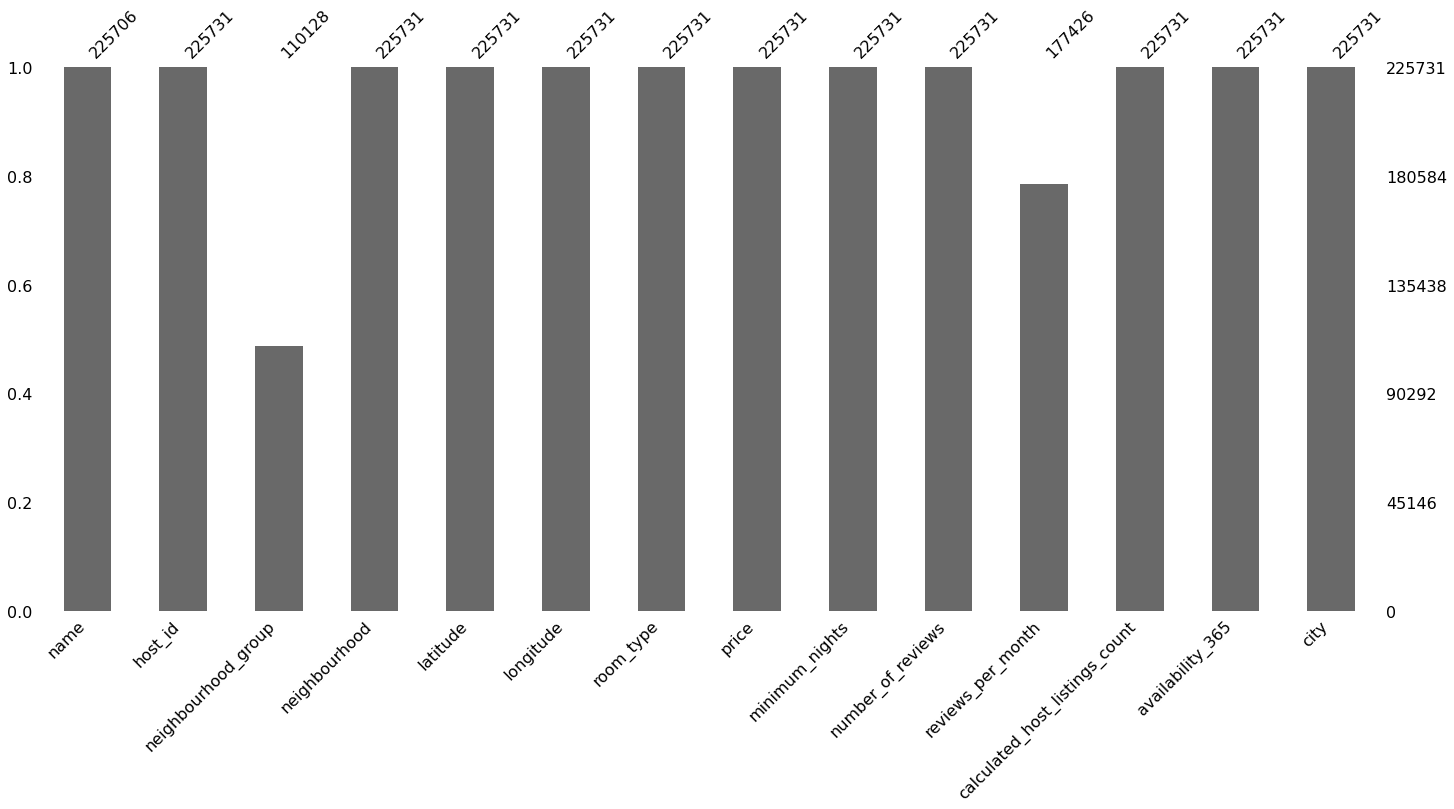

In [7]:
import missingno as msno
import pyspark.sql.functions as F
data_agg = df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])
data_agg.show()
#visualizing missing data
pandasDF = df.toPandas()
msno.bar(pandasDF)

We can see the columns 'neighbourhood_group' and 'reviews_per_month' have most of the null values. Dropping this much of rows will definitely result in the loss of meaningful data. So lets fill these columns with some values and then drop the remaining null rows.

+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----+
|name|host_id|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|city|
+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----+
|   0|      0|                  0|            0|       0|        0|        0|    0|             0|                0|                0|                             0|               0|   0|
+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----+



<AxesSubplot:>

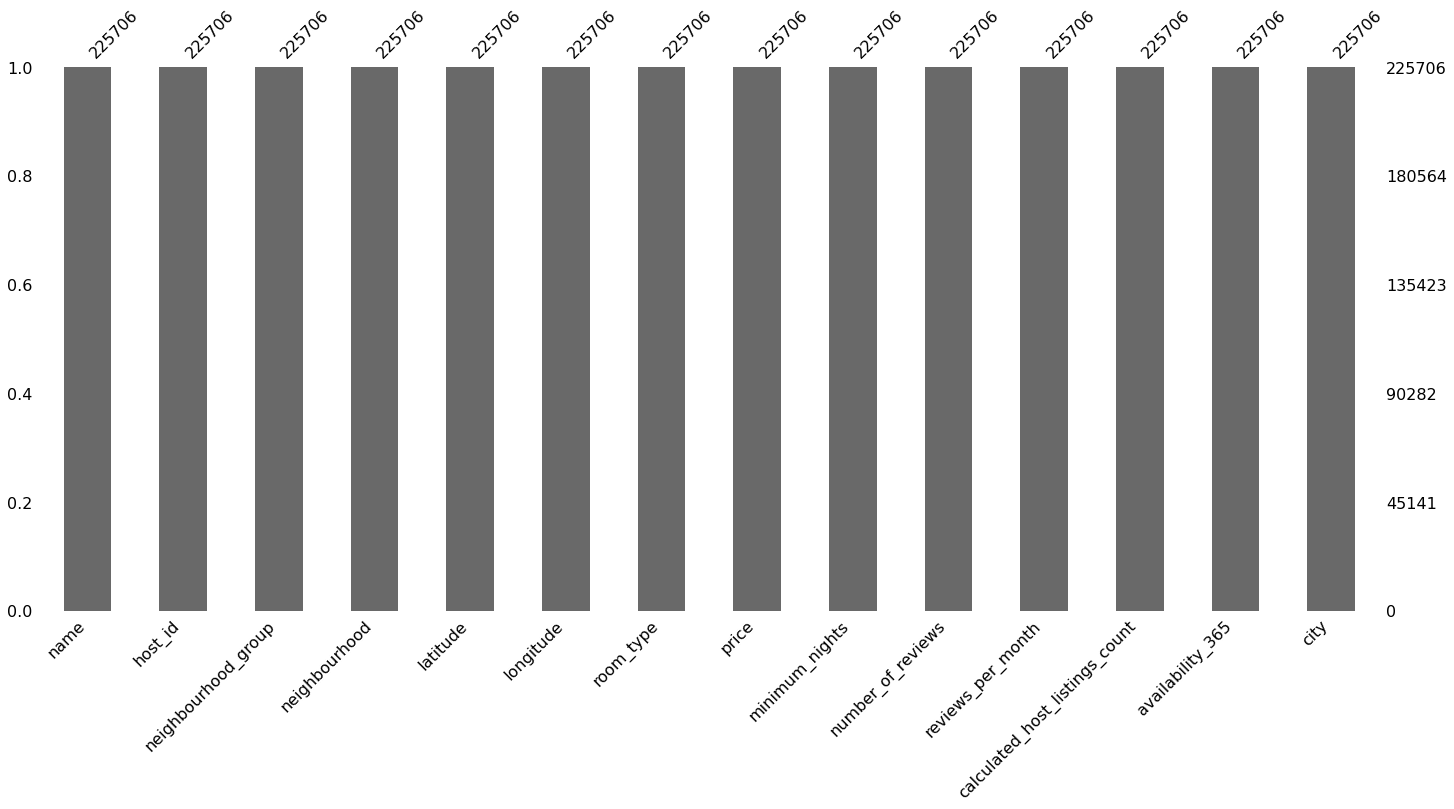

In [8]:
#filling missing values
df = df.na.fill( 0, 'reviews_per_month')
df = df.na.fill( 'Unknown', 'neighbourhood_group')
df = df.na.drop()

data_agg = df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])
data_agg.show()

pandasDF = df.toPandas()
msno.bar(pandasDF)

In [9]:
print("Total number of records after deleting duplicate and null rows from data is:" , df.count())

Total number of records after deleting duplicate and null rows from data is: 225706


7.Correcting features' data types

In [10]:
#casting features to correct datatype
from pyspark.sql.types import *

#function to convert the data type of DataFrame columns
def convertColumn(dataframe, names, newType):
    for name in names: 
        dataframe = dataframe.withColumn(name, dataframe[name].cast(newType))
    return dataframe 
# Lists of continuous features
DBL_FEATURES  = ['latitude','longitude','price','reviews_per_month']
INT_FEATURES = ['host_id','minimum_nights', 'number_of_reviews','calculated_host_listings_count', 'availability_365']
# Convert the type
df = convertColumn(df, DBL_FEATURES, DoubleType())
df = convertColumn(df, INT_FEATURES, IntegerType())
# Check the dataset
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- neighbourhood_group: string (nullable = false)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = false)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- city: string (nullable = true)



8. Examining Categorial Features

In [11]:
#Counting uniques values of all categorial featues
df.select(F.countDistinct('neighbourhood_group')).show()
df.select(F.countDistinct('neighbourhood')).show()
df.select(F.countDistinct('room_type')).show()
df.select(F.countDistinct('city')).show()

+-----------------------------------+
|count(DISTINCT neighbourhood_group)|
+-----------------------------------+
|                                 35|
+-----------------------------------+

+-----------------------------+
|count(DISTINCT neighbourhood)|
+-----------------------------+
|                         1450|
+-----------------------------+

+-------------------------+
|count(DISTINCT room_type)|
+-------------------------+
|                        4|
+-------------------------+

+--------------------+
|count(DISTINCT city)|
+--------------------+
|                  28|
+--------------------+



We can see that 'neighbourhood' has the most categories of 1450. This is a huge number and dealing with such a categorial feature would be problematic while modelling. So we drop 'neighbourhood' feature.

In [12]:
df = df.drop('neighbourhood')

Deleting categories with less occurences in categorial features

In [13]:
room_type_count = df.groupBy('room_type').count().where(F.col('count') > 2)
room_cat = list(room_type_count.select('room_type').toPandas()['room_type'])

city_count = df.groupBy('city').count().where(F.col('count') > 10)
city_cat = list(city_count.select('city').toPandas()['city'])

neighbourhood_group_count = df.groupBy('neighbourhood_group').count().where(F.col('count') > 50)
neighbourhood_group_cat = list(neighbourhood_group_count.select('neighbourhood_group').toPandas()['neighbourhood_group'])

In [14]:
df = df.filter(F.col('city').isin(city_cat)\
                       & F.col('neighbourhood_group').isin(neighbourhood_group_cat)\
                       & F.col('room_type').isin(room_cat))

In [15]:
#Examining features after deleting low occurence distinct values
df.select(F.countDistinct('neighbourhood_group')).show()
df.select(F.countDistinct('room_type')).show()
df.select(F.countDistinct('city')).show()

+-----------------------------------+
|count(DISTINCT neighbourhood_group)|
+-----------------------------------+
|                                 34|
+-----------------------------------+

+-------------------------+
|count(DISTINCT room_type)|
+-------------------------+
|                        4|
+-------------------------+

+--------------------+
|count(DISTINCT city)|
+--------------------+
|                  28|
+--------------------+



9. Renaming columns

In [16]:
df = df.withColumnRenamed('name', 'Desc')\
             .withColumnRenamed('host_id', 'hostID') \
             .withColumnRenamed('calculated_host_listings_count', 'host_listings')\
             .withColumnRenamed('availability_365', 'availability')

Examining data after preprocessing

In [17]:
print("Total records:", df.count())
print("Data has the following features:", df.columns)
df.printSchema()

Total records: 225672
Data has the following features: ['Desc', 'hostID', 'neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'host_listings', 'availability', 'city']
root
 |-- Desc: string (nullable = true)
 |-- hostID: integer (nullable = true)
 |-- neighbourhood_group: string (nullable = false)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = false)
 |-- host_listings: integer (nullable = true)
 |-- availability: integer (nullable = true)
 |-- city: string (nullable = true)



After data preprocessing we have 225672 records. Total 358(226030-225672) records are deleted in this preprocessing.

10. Saving the cleaned data as a new .csv file

In [18]:
dfp = df.toPandas()
dfp.to_csv('Data/Cleaned_data.csv', index=False)